In [1]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/SchwiftyNotebook_convolution_model")' SchwiftyNotebook_convolution_model

Installing packages:
	.package(path: "/home/ubuntu/workspace/fast-ai-swift/SchwiftyNotebook_convolution_model")
		SchwiftyNotebook_convolution_model
With SwiftPM flags: []
Working in: /tmp/tmpzs349oc3/swift-install
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version info

In [2]:
//export
import Path
import TensorFlow
import SchwiftyNotebook_convolution_model

In [3]:
import Python
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

public let plotter = Python.import("matplotlib.pyplot")

# Data Setup

In [4]:
let n = 100
let inputPoints = TensorFloat(randomNormal: [100, 1])
let A = inputPoints.concatenated(with: TensorFloat(ones: inputPoints.shape), alongAxis: 1)
A.shape

▿ [100, 2]
  ▿ dimensions : 2 elements
    - 0 : 100
    - 1 : 2


In [5]:
let yValidationPoints = matmul(A, TensorFloat([-2, 7]).expandingShape(at: 1)) + 
                (TensorFloat(randomNormal: inputPoints.shape, seed: (69, 420)) * 2.5)
yValidationPoints.shape

▿ [100, 1]
  ▿ dimensions : 2 elements
    - 0 : 100
    - 1 : 1


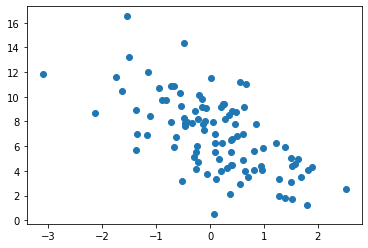

None


In [6]:
plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: yValidationPoints.makeNumpyArray())
plotter.show()

# Model Creation

In [7]:
@differentiable
func squareBoi(inputTensor: TensorFloat) -> TensorFloat {
    return inputTensor * inputTensor
}

let (squared, squareGradientChain) = valueWithPullback(at: TensorFloat([2, 3]), in: squareBoi)
print(squared)
print(type(of: squareGradientChain))

[4.0, 9.0]
(Tensor<Float>) -> Tensor<Float>


In [8]:
//tail recursion?
func loopyBoi(x: Int) {
    guard x > 0 else { return }
    print("Loopy Boi \(x)")
    return loopyBoi(x: x - 1)
}

loopyBoi(x: 5)

Loopy Boi 5
Loopy Boi 4
Loopy Boi 3
Loopy Boi 2
Loopy Boi 1


In [9]:
let tensorBoi = TensorFloat([1, 2, 3]).expandingShape(at: 1)
let weightParameter = TensorFloat(kaimingUniform: TensorShape([2, 1]))
let biasParameter = TensorFloat(zeros: [1])

In [31]:
func womboCombinator(inputTensor: TensorFloat, 
                     weightParameter: TensorFloat, 
                     biasParameter: TensorFloat) -> TensorFloat {
    return matmul(inputTensor, weightParameter) + biasParameter
}

@differentiating(womboCombinator)
func womboComboGradient(inputParameter: TensorFloat, 
                        weightParameter: TensorFloat, 
                        biasParameter: TensorFloat) -> (value: TensorFloat, 
                                                        pullback: (TensorFloat) -> 
                                                        (TensorFloat, TensorFloat, TensorFloat)) {
    //M x N * N x O = M x O
    return (value: womboCombinator(inputTensor: inputParameter, 
                                   weightParameter: weightParameter, 
                                   biasParameter: biasParameter), pullback: { ddx in (
        inputParameter,
        matmul(inputParameter.transposed(), ddx),
        ddx.unbroadcasted(to: biasParameter.shape)
    ) })
}

In [32]:
let (womboCombo, womboComboGradientChain) = valueWithPullback(at: A, 
                                                              weightParameter, 
                                                              biasParameter, 
                                                              in: womboCombinator)

In [33]:
func showYHat(yHat: TensorFloat) {
    plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: yValidationPoints.makeNumpyArray())
    plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: yHat.makeNumpyArray())
    plotter.show()
}

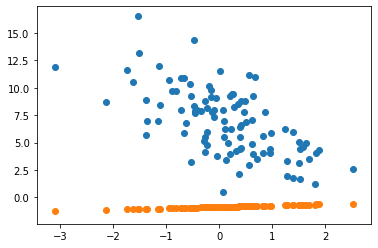

In [34]:
//first guess
showYHat(yHat: matmul(A, weightParameter))

In [35]:
let (activations, activationChain) = linearCombinationAndGradient(inputTensor: A, 
                                                                  weightParameter: weightParameter, 
                                                                  biasParameter: biasParameter)
let error = activations - yValidationPoints
let (squareValue, squareGradient) = squaredWithGradient(inputTensor: error)
let (meanValue, meanGradient) = meanWithGradient(inputTensor: squareValue)

// Time to go backward bois!
let ddxMean = meanGradient(TensorFloat([1]))
let ddxSquare = squareGradient(ddxMean)
let (ddxInput, ddxWeightParam, ddxBias) = activationChain(ddxSquare)

In [36]:
let (autoActivations, autoActivationChain) = valueWithPullback(at: A, 
                                                              weightParameter, 
                                                              biasParameter, 
                                                              in: womboCombinator)
assertEquals(activations, autoActivations, "Expected Auto Activations to be the same as mine")
let (_, autoDdxWeightParam, autoDdxBias) = autoActivationChain(ddxSquare)
assertEquals(autoDdxWeightParam, ddxWeightParam, "Expected weight gradient to be the same")
assertEquals(autoDdxBias, ddxBias, "Expected bias gradient to be the same")